# **Background**
Transcription factors are proteins that bind DNA at promoters to drive gene expression. Most preferentially bind to specific sequences while ignoring others. Traditional methods to determine these sequences (called motifs) have assumed that binding sites in the genome are all independent. However, in some cases people have identified motifs where positional interdependencies exist.

# **Task:**
Implement a multi-layer fully connected neural network using your NeuralNetwork class to predict whether a short DNA sequence is a binding site for the yeast transcription factor Rap1. The training data is incredibly imbalanced, with way fewer positive sequences than negative sequences, so you will implement a sampling scheme to ensure that class imbalance does not affect training.

In [44]:
# uploading nn.py

from google.colab import files
uploaded = files.upload()

Saving nn1.py to nn1.py
Saving preprocess.py to preprocess.py


In [90]:
# Imports
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nn import NeuralNetwork
from my_io import read_text_file, read_fasta_file
from preprocess import one_hot_encode_seqs, sample_seqs
from sklearn.metrics import accuracy_score

Use the read_text_file function from io.py to read in the 137 positive Rap1 motif examples

In [40]:
positive_seqs = read_text_file('rap1-lieb-positives.txt')

Use the read_fasta_file function from io.py to read in all the negative examples (Note that these sequences are much longer than the positive sequences, so you will need to process them to the same length)


In [41]:
negative_seqs = read_fasta_file('yeast-upstream-1k-negative.fa')

Sampling Scheme (see comments within code as well):

1. Balance your classes using sample_seq function

2. One-hot encode the data using your one_hot_encode_seqs function

3. Split the data into training and validation sets


In [93]:
# Step 1: Ensure both positive and negative sequences are of the same length
min_seq_length = min(len(seq) for seq in positive_seqs)  # Get the shortest sequence length
negative_seqs_trunc = [seq[:min_seq_length] for seq in negative_seqs]  # Truncate negative sequences

# Step 2: Combine positive and negative sequences
combined_seqs = positive_seqs + negative_seqs_trunc

# Step 3: Create labels for sequences (1 for positive, 0 for negative)
combined_labels = [1] * len(positive_seqs) + [0] * len(negative_seqs_trunc)

# Step 4: Shuffle the dataset to randomize the order
shuffled_indices = list(range(len(combined_seqs)))
random.shuffle(shuffled_indices)

# Shuffle both sequences and labels
shuffled_seqs = [combined_seqs[i] for i in shuffled_indices]
shuffled_labels = [combined_labels[i] for i in shuffled_indices]

# Step 5: Balance the dataset by sampling (oversampling the minority class)
sampled_seqs, sampled_labels = sample_seqs(shuffled_seqs, shuffled_labels, seed=8)

# Step 6: One-hot encode the sequences
encoded_seqs = one_hot_encode_seqs(sampled_seqs)

#  Reshape encoded_seqs to match the number of samples in sampled_labels
encoded_seqs = encoded_seqs.reshape(len(sampled_labels), -1) # Reshape encoded_seqs to have the correct number of samples (rows)

# Step 7: Split the dataset into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(encoded_seqs, sampled_labels, test_size=0.2, random_state=88)

# Step 8: Convert to numpy arrays for use in the model
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [94]:
print(X_train.shape)
print(y_train.shape)

(5060, 68)
(5060,)


Generate an instance of your NeuralNetwork class with an appropriate architecture

In [106]:
nn_architecture = [
    {'input_dim': 68, 'output_dim': 34, 'activation': 'sigmoid'},  # Input -> Hidden layer (68 -> 34)
    {'input_dim': 34, 'output_dim': 17, 'activation': 'sigmoid'}, # Hidden -> Hidden layer (34 -> 17)
    {'input_dim': 17, 'output_dim': 1, 'activation': 'sigmoid'}   # Hidden -> Output layer (17 -> 1)
]

learning_rate = 1e-2
random_seed = 8
batch_size = 100
epochs = 1000
loss_function = 'binary_cross_entropy'

network = NeuralNetwork(nn_architecture, learning_rate, random_seed, batch_size, epochs, loss_function)

Train your neural network on the training data

In [107]:
per_epoch_loss_train, per_epoch_loss_val = network.fit(np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val))

Plot your training and validation loss by epoch

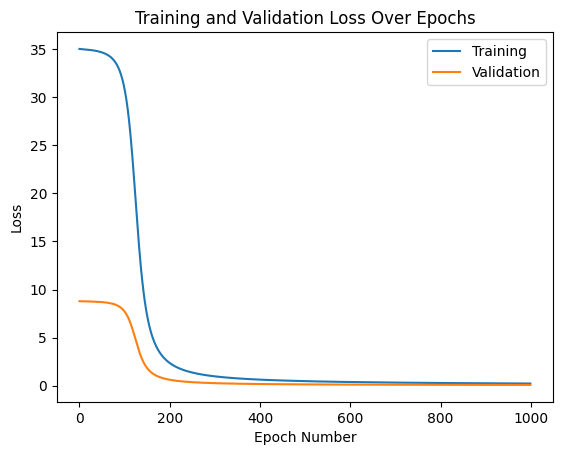

In [108]:
# Plotting
plt.plot(per_epoch_loss_train, label = 'Training')
plt.plot(per_epoch_loss_val, label = 'Validation')


plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

Report the accuracy of your classifier on your validation dataset

In [109]:
# Step 1: Predict outputs for the validation set
predictions = network.predict(X_val)  # Use your trained model's `predict` method

# Step 2: Round the predictions (if they are probabilities, you can round to get binary output)
predicted_labels = np.round(predictions)

# Step 3: Compare predicted labels with actual labels and calculate accuracy
accuracy = np.sum(predicted_labels == y_val) / len(y_val)  # Percentage of correct predictions

# Step 4: Print accuracy as a percentage (multiply by 100)
print(f'Validation accuracy: {accuracy*100:.2f}%')

Validation accuracy: 99.84%


Explain your choice of loss function and hyperparameters:

Accuracy is approximately 99.84%.
For the loss function, binary cross entropy was chosen as it is typically used for binary classification, similar to what we are doing here. Multiple layers were considered, as well as different activations. Parameters were chosen such to end with 1 dimension (classification) and to optimize accuracy.  